# recurrent neural network (RNN) + Val

In [1]:
import json
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Val

In [5]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notVal
select = df11[0].apply(lambda x: False if 'V' in x else True)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
df21 = df21.sample(frac=.5)
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
df31 = df31.sample(frac=.4)
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
False    1107677
True      757565
Name: count, dtype: int64
(757565, 2)
(3185991, 2) (1592996, 2)
(1863999, 2) (745599, 2)


In [6]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(3096160, 2)


,0,1
1557751,KAYDYFQAKKIPI,epitope
1460801,ADMIMHTPGC,epitope
1013752,VPTAEFDNWRKDENM,random
2737745,QYACLHDLTN,other
116688,PRESMLLALASCLLQ,epitope


In [7]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'KAYDYFQAKKIPI')
Counter({'other': 1592996, 'epitope': 757565, 'random': 745599})


In [8]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'QRFTDDAIE')
split data:  1857696 619232 619232

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: AEKSRGRRI ['A', 'E', 'K', 'S', 'R', 'G', 'R', 'R', 'I']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 1840810), ('S', 1556332), ('A', 1518756), ('E', 1433764), ('G', 1421285), ('P', 1263443), ('K', 1235782), ('R', 1191316), ('T', 1182042), ('D', 1117925), ('I', 1048110), ('Q', 1028133), ('V', 920929), ('N', 917213), ('F', 889137), ('Y', 760588), ('H', 672723), ('M', 616826), ('C', 604545), ('W', 486627), ('X', 1665), ('U', 46), ('Z', 27), ('B', 21), ('J', 2)])
counts of input: [955663, 454674, 447359]

## Step 3 encoding: encoding each unique token into integers...


In [9]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8530 val_acc: 0.8591, val_recall: 0.7873
Epoch 1 acc: 0.8635 val_acc: 0.8650, val_recall: 0.8251
Epoch 2 acc: 0.8667 val_acc: 0.8671, val_recall: 0.8148
Epoch 3 acc: 0.8691 val_acc: 0.8676, val_recall: 0.8274
Epoch 4 acc: 0.8707 val_acc: 0.8673, val_recall: 0.8340
Epoch 5 acc: 0.8719 val_acc: 0.8687, val_recall: 0.8146
Epoch 6 acc: 0.8732 val_acc: 0.8684, val_recall: 0.8200
Epoch 7 acc: 0.8741 val_acc: 0.8690, val_recall: 0.8111
Epoch 8 acc: 0.8748 val_acc: 0.8688, val_recall: 0.8193
Epoch 9 acc: 0.8755 val_acc: 0.8696, val_recall: 0.8200
Epoch 10 acc: 0.8756 val_acc: 0.8693, val_recall: 0.8223
Epoch 11 acc: 0.8767 val_acc: 0.8693, val_recall: 0.8206
Epoch 12 acc: 0.8771 val_acc: 0.8689, val_recall: 0.8278
Epoch 13 acc: 0.8770 val_acc: 0.8690, val_recall: 0.8174
Epoch 14 acc: 0.8776 val_acc: 0.8690, val_recall: 0.8226
Epoch 15 acc: 0.8777 val_acc: 0.8690, val_recall: 0.8206
Epoch 16 acc: 0.8775 val_acc: 0.8676, val_recall: 0.8210
Epoch 17 acc: 0.8780 val_acc: 0.8683, val

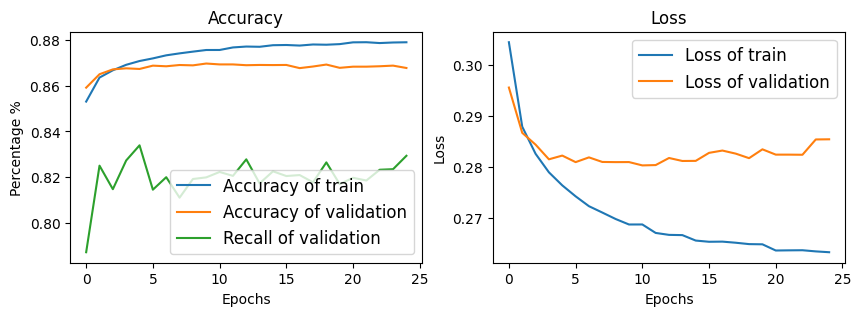

In [11]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [12]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8280335182210052,
 'accuracy': 0.8666977804764612,
 'loss': 0.2862103477096913}

In [13]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

150921 468311


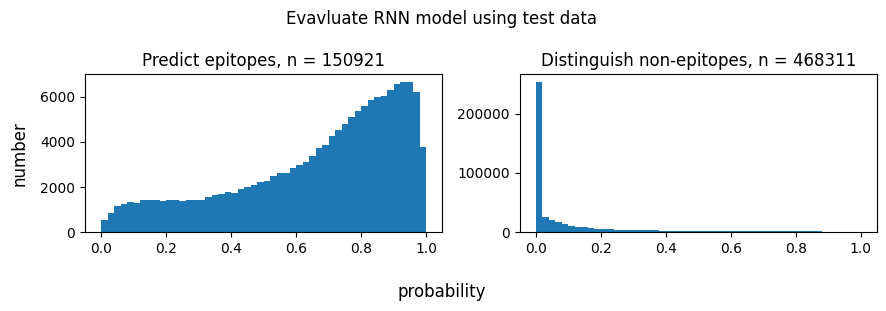

In [14]:
MyEvaluate.plot_prob(pred_test)

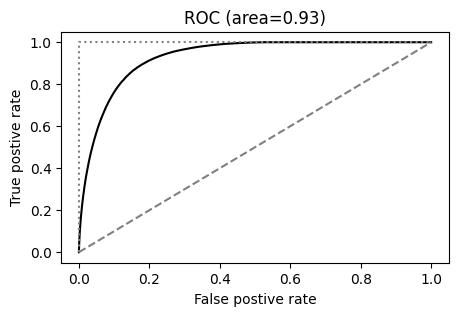

In [15]:
MyEvaluate.plot_roc(pred_test)

In [16]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notVal.pth')

## has Val

In [17]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep Cys
select = df11[0].apply(lambda x: True if 'V' in x else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

(1865242, 2) (1865242, 2)
0
True     1107677
False     757565
Name: count, dtype: int64
(1107677, 2)


In [18]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(3446272, 2)


In [20]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'SLATVAYFNMVYMPA')
Counter({'other': 1592996, 'epitope': 1107677, 'random': 745599})


In [21]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'NRCMHWQAS')
split data:  2067763 689254 689255

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: AQSCYQKWHPYM ['A', 'Q', 'S', 'C', 'Y', 'Q', 'K', 'W', 'H', 'P', 'Y', 'M']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2058477), ('V', 1957068), ('A', 1742593), ('S', 1737940), ('G', 1614293), ('E', 1576419), ('K', 1409337), ('P', 1403926), ('T', 1360380), ('R', 1320368), ('D', 1285748), ('I', 1172286), ('Q', 1118938), ('N', 1048638), ('F', 992884), ('Y', 838281), ('H', 737021), ('M', 662447), ('C', 646880), ('W', 514117), ('X', 1693), ('U', 43), ('Z', 20), ('B', 14), ('J', 2)])
counts of input: [955188, 665249, 447326]

## Step 3 encoding: encoding each unique token into integers...


In [22]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [23]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8311 val_acc: 0.8405, val_recall: 0.8384
Epoch 1 acc: 0.8432 val_acc: 0.8447, val_recall: 0.8315
Epoch 2 acc: 0.8463 val_acc: 0.8463, val_recall: 0.8384
Epoch 3 acc: 0.8473 val_acc: 0.8470, val_recall: 0.8414
Epoch 4 acc: 0.8450 val_acc: 0.8446, val_recall: 0.8300
Epoch 5 acc: 0.8471 val_acc: 0.8431, val_recall: 0.8384
Epoch 6 acc: 0.8465 val_acc: 0.8469, val_recall: 0.8377
Epoch 7 acc: 0.8501 val_acc: 0.8478, val_recall: 0.8283
Epoch 8 acc: 0.8518 val_acc: 0.8488, val_recall: 0.8384
Epoch 9 acc: 0.8527 val_acc: 0.8481, val_recall: 0.8351
Epoch 10 acc: 0.8536 val_acc: 0.8472, val_recall: 0.8395
Epoch 11 acc: 0.8544 val_acc: 0.8490, val_recall: 0.8440
Epoch 12 acc: 0.8545 val_acc: 0.8495, val_recall: 0.8429
Epoch 13 acc: 0.8552 val_acc: 0.8499, val_recall: 0.8414
Epoch 14 acc: 0.8552 val_acc: 0.8497, val_recall: 0.8369
Epoch 15 acc: 0.8564 val_acc: 0.8492, val_recall: 0.8334
Epoch 16 acc: 0.8566 val_acc: 0.8487, val_recall: 0.8275
Epoch 17 acc: 0.8570 val_acc: 0.8499, val

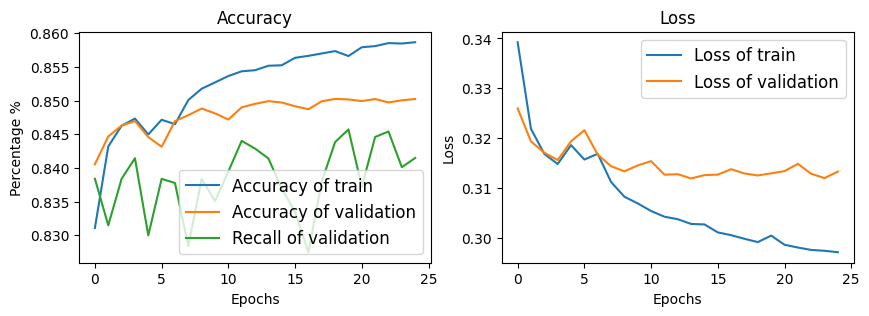

In [24]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [25]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8402267919436268,
 'accuracy': 0.8491443660183822,
 'loss': 0.31393571583943874}

In [26]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,STCPIALKSIS,5.504853e-10,other
1,IIRGMDMGAK,8.988718e-08,other
2,DIDARPAVLLVIPAD,4.725467e-01,other
3,HPVGEADYFEY,9.391186e-01,epitope
4,LAAAALRQR,3.098889e-09,other


221093 468162


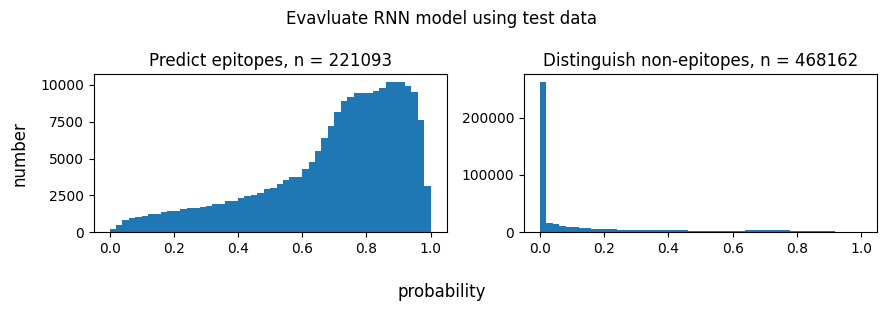

In [27]:
MyEvaluate.plot_prob(pred_test)

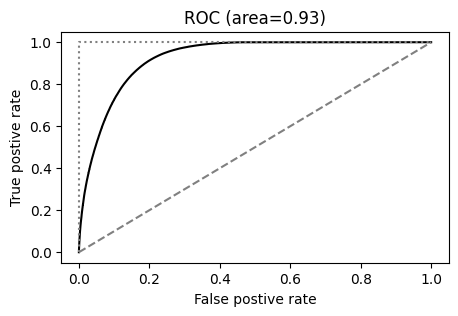

In [28]:
MyEvaluate.plot_roc(pred_test)

In [29]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_Val.pth')